# Connecting the notebook

In [1]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse 



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.

In [2]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive 

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 123947 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-36build1_amd64.deb ...
Unpacking w3m (0.5.3-36build1) ...
Setting up w3m (0.5.3-36build1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


# importation

In [3]:
import itertools
import os
import random
import six
import numpy as np
import cv2

In [4]:
try:
    from collections.abc import Sequence
except ImportError:
    from collections import Sequence

try:
    from tqdm import tqdm
except ImportError:
    print("tqdm not found, disabling progress bars")

def tqdm(iter):
    return iter

In [5]:
#fixing the seed
import tensorflow as tf
seed_value=1254
#os.environ['PYTHONHASHSEEN']='0'
os.environ['PYTHONHASHSEEN']='1254'
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
#DATA_LOADER_SEED = 1254
random.seed(seed_value)
from tensorflow import random as tr
tr.set_seed(1234)

## Taking care of reproducibility 

In [6]:
import tensorflow as tf
from tensorflow import random as tr
seed_value=1254
os.environ['PYTHONHASHSEEN']='0'
random.seed(seed_value)
np.random.seed(seed_value)
tr.set_seed(1234)
#confihgure a new global tensorflow session 


In [ ]:
#from keras import backend as k
#session_conf= tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf) 
#tf.compat.v1.keras.backend.set_session(sess)

# Necessary functions 

In [7]:
IMAGE_ORDERING_CHANNELS_LAST = "channels_last"
IMAGE_ORDERING_CHANNELS_FIRST = "channels_first"

# Default IMAGE_ORDERING = channels_last
IMAGE_ORDERING = IMAGE_ORDERING_CHANNELS_LAST

In [8]:
#augmentation 

import numpy as np

try:
    import imgaug as ia
    from imgaug import augmenters as iaa
except ImportError:
    print("Error in loading augmentation, can't import imgaug."
          "Please make sure it is installed.")


IMAGE_AUGMENTATION_SEQUENCE = None
IMAGE_AUGMENTATION_NUM_TRIES = 10

loaded_augmentation_name = ""


def _load_augmentation_aug_geometric():
    return iaa.OneOf([
        iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.2)]),
        iaa.CropAndPad(percent=(-0.05, 0.1),
                       pad_mode='constant',
                       pad_cval=(0, 255)),
        iaa.Crop(percent=(0.0, 0.1)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Sequential([
            iaa.Affine(
                    # scale images to 80-120% of their size,
                    # individually per axis
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    # translate by -20 to +20 percent (per axis)
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                    rotate=(-45, 45),  # rotate by -45 to +45 degrees
                    shear=(-16, 16),  # shear by -16 to +16 degrees
                    # use nearest neighbour or bilinear interpolation (fast)
                    order=[0, 1],
                    # if mode is constant, use a cval between 0 and 255
                    mode='constant',
                    cval=(0, 255),
                    # use any of scikit-image's warping modes
                    # (see 2nd image from the top for examples)
            ),
            iaa.Sometimes(0.3, iaa.Crop(percent=(0.3, 0.5)))])
    ])


def _load_augmentation_aug_non_geometric():
    return iaa.Sequential([
        iaa.Sometimes(0.3, iaa.Multiply((0.5, 1.5), per_channel=0.5)),
        iaa.Sometimes(0.2, iaa.JpegCompression(compression=(70, 99))),
        iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Sometimes(0.2, iaa.MotionBlur(k=15, angle=[-45, 45])),
        iaa.Sometimes(0.2, iaa.MultiplyHue((0.5, 1.5))),
        iaa.Sometimes(0.2, iaa.MultiplySaturation((0.5, 1.5))),
        iaa.Sometimes(0.34, iaa.MultiplyHueAndSaturation((0.5, 1.5),
                                                         per_channel=True)),
        iaa.Sometimes(0.34, iaa.Grayscale(alpha=(0.0, 1.0))),
        iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.1, iaa.GammaContrast((0.5, 2.0))),
        iaa.Sometimes(0.2, iaa.SigmoidContrast(gain=(3, 10),
                                               cutoff=(0.4, 0.6))),
        iaa.Sometimes(0.1, iaa.CLAHE()),
        iaa.Sometimes(0.1, iaa.HistogramEqualization()),
        iaa.Sometimes(0.2, iaa.LinearContrast((0.5, 2.0), per_channel=0.5)),
        iaa.Sometimes(0.1, iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)))
    ])


def _load_augmentation_aug_all2():
    return iaa.Sequential([
        iaa.Sometimes(0.65, _load_augmentation_aug_non_geometric()),
        iaa.Sometimes(0.65, _load_augmentation_aug_geometric())
    ])


def _load_augmentation_aug_all():
    """ Load image augmentation model """

    def sometimes(aug):
        return iaa.Sometimes(0.5, aug)

    return iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5),  # horizontally flip 50% of all images
            iaa.Flipud(0.2),  # vertically flip 20% of all images
            # crop images by -5% to 10% of their height/width
            sometimes(iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode='constant',
                pad_cval=(0, 255)
            )),
            sometimes(iaa.Affine(
                # scale images to 80-120% of their size, individually per axis
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                # translate by -20 to +20 percent (per axis)
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-45, 45),  # rotate by -45 to +45 degrees
                shear=(-16, 16),  # shear by -16 to +16 degrees
                # use nearest neighbour or bilinear interpolation (fast)
                order=[0, 1],
                # if mode is constant, use a cval between 0 and 255
                cval=(0, 255),
                # use any of scikit-image's warping modes
                # (see 2nd image from the top for examples)
                mode='constant'
            )),
            # execute 0 to 5 of the following (less important) augmenters per
            # image don't execute all of them, as that would often be way too
            # strong
            iaa.SomeOf((0, 5),
                       [
                # convert images into their superpixel representation
                sometimes(iaa.Superpixels(
                    p_replace=(0, 1.0), n_segments=(20, 200))),
                iaa.OneOf([
                    # blur images with a sigma between 0 and 3.0
                    iaa.GaussianBlur((0, 3.0)),
                    # blur image using local means with kernel sizes
                    # between 2 and 7
                    iaa.AverageBlur(k=(2, 7)),
                    # blur image using local medians with kernel sizes
                    # between 2 and 7
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(
                            0.75, 1.5)),  # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(
                    0, 2.0)),  # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.BlendAlphaSimplexNoise(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                # add gaussian noise to images
                iaa.AdditiveGaussianNoise(loc=0, scale=(
                    0.0, 0.05*255), per_channel=0.5),
                iaa.OneOf([
                    # randomly remove up to 10% of the pixels
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(
                        0.02, 0.05), per_channel=0.2),
                ]),
                # invert color channels
                iaa.Invert(0.05, per_channel=True),
                # change brightness of images (by -10 to 10 of original value)
                iaa.Add((-10, 10), per_channel=0.5),
                # change hue and saturation
                iaa.AddToHueAndSaturation((-20, 20)),
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply(
                                (0.5, 1.5), per_channel=0.5),
                    iaa.BlendAlphaFrequencyNoise(
                        exponent=(-4, 0),
                        foreground=iaa.Multiply(
                            (0.5, 1.5), per_channel=True),
                        background=iaa.contrast.LinearContrast(
                            (0.5, 2.0))
                    )
                ]),
                # improve or worsen the contrast
                iaa.contrast.LinearContrast((0.5, 2.0), per_channel=0.5),
                iaa.Grayscale(alpha=(0.0, 1.0)),
                # move pixels locally around (with random strengths)
                sometimes(iaa.ElasticTransformation(
                    alpha=(0.5, 3.5), sigma=0.25)),
                # sometimes move parts of the image around
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
                random_order=True
            )
        ],
        random_order=True
    )


augmentation_functions = {
    "aug_all": _load_augmentation_aug_all,
    "aug_all2": _load_augmentation_aug_all2,
    "aug_geometric": _load_augmentation_aug_geometric,
    "aug_non_geometric": _load_augmentation_aug_non_geometric
}


def _load_augmentation(augmentation_name="aug_all"):

    global IMAGE_AUGMENTATION_SEQUENCE

    if augmentation_name not in augmentation_functions:
        raise ValueError("Augmentation name not supported")

    IMAGE_AUGMENTATION_SEQUENCE = augmentation_functions[augmentation_name]()


def _augment_seg(img, seg, augmentation_name="aug_all", other_imgs=None):

    global loaded_augmentation_name

    if (not IMAGE_AUGMENTATION_SEQUENCE) or\
       (augmentation_name != loaded_augmentation_name):
        _load_augmentation(augmentation_name)
        loaded_augmentation_name = augmentation_name

    # Create a deterministic augmentation from the random one
    aug_det = IMAGE_AUGMENTATION_SEQUENCE.to_deterministic()
    # Augment the input image
    image_aug = aug_det.augment_image(img)

    if other_imgs is not None:
        image_aug = [image_aug]

        for other_img in other_imgs:
            image_aug.append(aug_det.augment_image(other_img))

    segmap = ia.SegmentationMapsOnImage(
        seg, shape=img.shape)
    segmap_aug = aug_det.augment_segmentation_maps(segmap)
    segmap_aug = segmap_aug.get_arr()

    return image_aug, segmap_aug


def _custom_augment_seg(img, seg, augmentation_function, other_imgs=None):
    augmentation_functions['custom_aug'] = augmentation_function

    return _augment_seg(img, seg, "custom_aug", other_imgs=other_imgs)


def _try_n_times(fn, n, *args, **kargs):
    """ Try a function N times """
    attempts = 0
    while attempts < n:
        try:
            return fn(*args, **kargs)
        except Exception:
            attempts += 1

    return fn(*args, **kargs)


def augment_seg(img, seg, augmentation_name="aug_all", other_imgs=None):
    return _try_n_times(_augment_seg, IMAGE_AUGMENTATION_NUM_TRIES,
                        img, seg, augmentation_name=augmentation_name,
                        other_imgs=other_imgs)


def custom_augment_seg(img, seg, augmentation_function, other_imgs=None):
    return _try_n_times(_custom_augment_seg, IMAGE_AUGMENTATION_NUM_TRIES,
                        img, seg, augmentation_function=augmentation_function,
                        other_imgs=other_imgs)



In [9]:


class_colors = [(random.randint(0, 255), random.randint(
    0, 255), random.randint(0, 255)) for _ in range(5000)]


ACCEPTABLE_IMAGE_FORMATS = [".jpg", ".jpeg", ".png", ".bmp"]
ACCEPTABLE_SEGMENTATION_FORMATS = [".png", ".bmp"]


class DataLoaderError(Exception):
    pass



def get_image_list_from_path(images_path ):
    image_files = []
    for dir_entry in os.listdir(images_path):
            if os.path.isfile(os.path.join(images_path, dir_entry)) and \
                    os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
                file_name, file_extension = os.path.splitext(dir_entry)
                image_files.append(os.path.join(images_path, dir_entry))
    return image_files


def get_pairs_from_paths(images_path, segs_path, ignore_non_matching=False, other_inputs_paths=None):
    """ Find all the images from the images_path directory and
        the segmentation images from the segs_path directory
        while checking integrity of data """



    image_files = []
    segmentation_files = {}

    for dir_entry in os.listdir(images_path):
        if os.path.isfile(os.path.join(images_path, dir_entry)) and \
                os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            image_files.append((file_name, file_extension,
                                os.path.join(images_path, dir_entry)))

    if other_inputs_paths is not None:
        other_inputs_files = []

        for i, other_inputs_path in enumerate(other_inputs_paths):
            temp = []

            for y, dir_entry in enumerate(os.listdir(other_inputs_path)):
                if os.path.isfile(os.path.join(other_inputs_path, dir_entry)) and \
                        os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
                    file_name, file_extension = os.path.splitext(dir_entry)

                    temp.append((file_name, file_extension,
                                 os.path.join(other_inputs_path, dir_entry)))

            other_inputs_files.append(temp)

    for dir_entry in os.listdir(segs_path):
        if os.path.isfile(os.path.join(segs_path, dir_entry)) and \
           os.path.splitext(dir_entry)[1] in ACCEPTABLE_SEGMENTATION_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            full_dir_entry = os.path.join(segs_path, dir_entry)
            if file_name in segmentation_files:
                raise DataLoaderError("Segmentation file with filename {0}"
                                      " already exists and is ambiguous to"
                                      " resolve with path {1}."
                                      " Please remove or rename the latter."
                                      .format(file_name, full_dir_entry))

            segmentation_files[file_name] = (file_extension, full_dir_entry)

    return_value = []
    # Match the images and segmentations
    for image_file, _, image_full_path in image_files:
        if image_file in segmentation_files:
            if other_inputs_paths is not None:
                other_inputs = []
                for file_paths in other_inputs_files:
                    success = False

                    for (other_file, _, other_full_path) in file_paths:
                        if image_file == other_file:
                            other_inputs.append(other_full_path)
                            success = True
                            break

                    if not success:
                        raise ValueError("There was no matching other input to", image_file, "in directory")

                return_value.append((image_full_path,
                                     segmentation_files[image_file][1], other_inputs))
            else:
                return_value.append((image_full_path,
                                     segmentation_files[image_file][1]))
        elif ignore_non_matching:
            continue
        else:
            # Error out
            raise DataLoaderError("No corresponding segmentation "
                                  "found for image {0}."
                                  .format(image_full_path))

    return return_value


def get_image_array(image_input,
                    width, height,
                    imgNorm="sub_mean", ordering='channels_first', read_image_type=1):
    """ Load image array from input """

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, six.string_types):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_image_array: path {0} doesn't exist"
                                  .format(image_input))
        img = cv2.imread(image_input, read_image_type)
    else:
        raise DataLoaderError("get_image_array: Can't process input type {0}"
                              .format(str(type(image_input))))

    if imgNorm == "sub_and_divide":
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == "sub_mean":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = np.atleast_3d(img)

        means = [103.939, 116.779, 123.68]

        for i in range(min(img.shape[2], len(means))):
            img[:, :, i] -= means[i]

        img = img[:, :, ::-1]
    elif imgNorm == "divide":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img/255.0

    if ordering == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    return img


def get_segmentation_array(image_input, nClasses,
                           width, height, no_reshape=False, read_image_type=1):
    """ Load segmentation array from input """

    seg_labels = np.zeros((height, width, nClasses))

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, six.string_types):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_segmentation_array: "
                                  "path {0} doesn't exist".format(image_input))
        img = cv2.imread(image_input, read_image_type)
    else:
        raise DataLoaderError("get_segmentation_array: "
                              "Can't process input type {0}"
                              .format(str(type(image_input))))

    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    img = img[:, :, 0]

    for c in range(nClasses):
        seg_labels[:, :, c] = (img == c).astype(int)

    if not no_reshape:
        seg_labels = np.reshape(seg_labels, (width*height, nClasses))

    return seg_labels


def verify_segmentation_dataset(images_path, segs_path,
                                n_classes, show_all_errors=False):
    try:
        img_seg_pairs = get_pairs_from_paths(images_path, segs_path)
        if not len(img_seg_pairs):
            print("Couldn't load any data from images_path: "
                  "{0} and segmentations path: {1}"
                  .format(images_path, segs_path))
            return False

        return_value = True
        for im_fn, seg_fn in tqdm(img_seg_pairs):
            img = cv2.imread(im_fn)
            #image = cv2.imread(im_fn)
            #img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            seg = cv2.imread(seg_fn)
            # Check dimensions match
            if not img.shape == seg.shape:
                return_value = False
                print("The size of image {0} and its segmentation {1} "
                      "doesn't match (possibly the files are corrupt)."
                      .format(im_fn, seg_fn))
                if not show_all_errors:
                    break
            else:
                max_pixel_value = np.max(seg[:, :, 0])
                if max_pixel_value >= n_classes:
                    return_value = False
                    print("The pixel values of the segmentation image {0} "
                          "violating range [0, {1}]. "
                          "Found maximum pixel value {2}"
                          .format(seg_fn, str(n_classes - 1), max_pixel_value))
                    if not show_all_errors:
                        break
        if return_value:
            print("Dataset verified! ")
        else:
            print("Dataset not verified!")
        return return_value
    except DataLoaderError as e:
        print("Found error during data loading\n{0}".format(str(e)))
        return False


def image_segmentation_generator(images_path, segs_path, batch_size,
                                 n_classes, input_height, input_width,
                                 output_height, output_width,
                                 do_augment=False,
                                 augmentation_name="aug_all",
                                 custom_augmentation=None,
                                 other_inputs_paths=None, preprocessing=None,
                                 read_image_type=cv2.IMREAD_COLOR , ignore_segs=False ):
    

    if not ignore_segs:
        img_seg_pairs = get_pairs_from_paths(images_path, segs_path, other_inputs_paths=other_inputs_paths)
        random.shuffle(img_seg_pairs)
        zipped = itertools.cycle(img_seg_pairs)
    else:
        img_list = get_image_list_from_path( images_path )
        random.shuffle( img_list )
        img_list_gen = itertools.cycle( img_list )


    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            if other_inputs_paths is None:

                if ignore_segs:
                    im = next( img_list_gen )
                    seg = None 
                else:
                    im, seg = next(zipped)
                    seg = cv2.imread(seg, 1)

                im = cv2.imread(im, read_image_type)
                

                if do_augment:

                    assert ignore_segs == False , "Not supported yet"

                    if custom_augmentation is None:
                        im, seg[:, :, 0] = augment_seg(im, seg[:, :, 0],
                                                       augmentation_name)
                    else:
                        im, seg[:, :, 0] = custom_augment_seg(im, seg[:, :, 0],
                                                              custom_augmentation)

                if preprocessing is not None:
                    im = preprocessing(im)

                X.append(get_image_array(im, input_width,
                                         input_height, ordering=IMAGE_ORDERING))
            else:

                assert ignore_segs == False , "Not supported yet"

                im, seg, others = next(zipped)

                im = cv2.imread(im, read_image_type)
                seg = cv2.imread(seg, 1)

                oth = []
                for f in others:
                    oth.append(cv2.imread(f, read_image_type))

                if do_augment:
                    if custom_augmentation is None:
                        ims, seg[:, :, 0] = augment_seg(im, seg[:, :, 0],
                                                        augmentation_name, other_imgs=oth)
                    else:
                        ims, seg[:, :, 0] = custom_augment_seg(im, seg[:, :, 0],
                                                               custom_augmentation, other_imgs=oth)
                else:
                    ims = [im]
                    ims.extend(oth)

                oth = []
                for i, image in enumerate(ims):
                    oth_im = get_image_array(image, input_width,
                                             input_height, ordering=IMAGE_ORDERING)

                    if preprocessing is not None:
                        if isinstance(preprocessing, Sequence):
                            oth_im = preprocessing[i](oth_im)
                        else:
                            oth_im = preprocessing(oth_im)

                    oth.append(oth_im)

                X.append(oth)

            if not ignore_segs:
                Y.append(get_segmentation_array(
                    seg, n_classes, output_width, output_height))

        if ignore_segs:
            yield np.array(X)
        else:
            yield np.array(X), np.array(Y)


# Architetureture

In [10]:
import keras
import tensorflow as tf

from tqdm import tqdm 
import numpy as np
import six 
import os 
import json 
import sys 

#from .data_utils.data_loader import image_segmentation_generator
#from .train import CheckpointsCallback 

from keras.models import Model 



def get_pariwise_similarities( feats ):
    feats_i = tf.reshape( feats , (-1 , 1 , feats.shape[1]*feats.shape[2] , feats.shape[3]))
    feats_j = tf.reshape( feats , (-1 ,  feats.shape[1]*feats.shape[2] , 1 , feats.shape[3]))
    
    feats_i = feats_i / (( tf.reduce_sum(feats_i**2 , axis=-1 ) )**(0.5))[ ... , None ]
    feats_j = feats_j / (( tf.reduce_sum(feats_j**2 , axis=-1 ) )**(0.5))[ ... , None ]
    
    feats_ixj = feats_i*feats_j
    
    return tf.reduce_sum( feats_ixj , axis=-1  )
    

    
def pairwise_dist_loss( feats_t , feats_s ):
    
    # todo max POOL     
    pool_factor = 4
    
    feats_t = tf.nn.max_pool(feats_t , (pool_factor,pool_factor) , strides=(pool_factor,pool_factor) , padding="VALID" )
    feats_s = tf.nn.max_pool(feats_s , (pool_factor,pool_factor) , strides=(pool_factor,pool_factor) , padding="VALID" )
            
    sims_t  = get_pariwise_similarities( feats_t )
    sims_s = get_pariwise_similarities( feats_s )
    n_pixs = sims_s.shape[1]
    
    return tf.reduce_sum(tf.reduce_sum(((sims_t - sims_s )**2 ) , axis=1), axis=1)/(n_pixs**2 )



class Distiller(keras.Model):
    def __init__(self, student, teacher , distilation_loss , feats_distilation_loss=None , feats_distilation_loss_w=0.1   ):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
        self.distilation_loss = distilation_loss
        
        self.feats_distilation_loss = feats_distilation_loss 
        self.feats_distilation_loss_w = feats_distilation_loss_w 
        
        if not feats_distilation_loss is None:
            try:
                s_feat_out = student.get_layer("seg_feats").output
            except:
                s_feat_out = student.get_layer(student.seg_feats_layer_name ).output
            
            
            try:
                t_feat_out = teacher.get_layer("seg_feats").output 
            except:
                t_feat_out = teacher.get_layer(teacher.seg_feats_layer_name ).output
            
            
            self.student_feat_model = Model( student.input , s_feat_out  )
            self.teacher_feat_model = Model( teacher.input , t_feat_out  )

    def compile(
        self,
        optimizer,
        metrics,

    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)


    def train_step(self, data):
        teacher_input ,  = data 
        
        student_input = tf.image.resize( teacher_input , ( self.student.input_height , self.student.input_width ) )

        teacher_predictions = self.teacher(teacher_input, training=False)
        teacher_predictions_reshape = tf.reshape(teacher_predictions , ((-1   , self.teacher.output_height , self.teacher.output_width , self.teacher.output_shape[-1])))
        
        
        if not self.feats_distilation_loss is None:
            teacher_feats = self.teacher_feat_model(teacher_input, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student( student_input , training=True)
            student_predictions_resize = tf.reshape(student_predictions , ((-1, self.student.output_height , self.student.output_width , self.student.output_shape[-1])))
            student_predictions_resize = tf.image.resize( student_predictions_resize , ( self.teacher.output_height , self.teacher.output_width ) )
            
            loss = self.distilation_loss( teacher_predictions_reshape , student_predictions_resize )
            
            if not self.feats_distilation_loss is None:
                student_feats = self.student_feat_model( student_input , training=True)
                student_feats_resize = tf.image.resize( student_feats , ( teacher_feats.shape[1] , teacher_feats.shape[2] ) )
                loss += self.feats_distilation_loss_w*self.feats_distilation_loss( teacher_feats , student_feats_resize )
            
            
            

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(teacher_predictions_reshape , student_predictions_resize )
        

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {  "distillation_loss": loss}
        )
        return results

#### Moving to the locals files 

In [11]:
import sys
pathg = '/content/drive/MyDrive/Colab Notebooks/plot_delineation/'
# path to pac
sys.path.append(pathg)

In [12]:
from vgg16 import get_vgg_encoder
from mobilenet import get_mobilenet_encoder
from basic_models import vanilla_encoder
from resnet50 import get_resnet50_encoder

In [13]:
from keras.metrics import Precision, Recall

# Learning rate selection 

To find the ideal learning rate(the learning rate where the loss decreases the most during training), we're oing to use the following steps:


In [ ]:

from keras.models import *
from keras.layers import *

from config import IMAGE_ORDERING
import json
import os
import six
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import glob
import sys


In [ ]:
def _unet(n_classes, encoder, l1_skip_conn=True, input_height=416,
          input_width=608, channels=3):

    img_input, levels = encoder(
        input_height=input_height, input_width=input_width, channels=channels)
    [f1, f2, f3, f4, f5] = levels

    o = f4

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(512, (3, 3), padding='valid' , activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f3], axis=MERGE_AXIS))
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(256, (3, 3), padding='valid', activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f2], axis=MERGE_AXIS))
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(128, (3, 3), padding='valid' , activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)

    if l1_skip_conn:
        o = (concatenate([o, f1], axis=MERGE_AXIS))

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(64, (3, 3), padding='valid', activation='relu', data_format=IMAGE_ORDERING, name="seg_feats"))(o)
    o = (BatchNormalization())(o)

    o = Conv2D(n_classes, (3, 3), padding='same',
               data_format=IMAGE_ORDERING)(o)

    model = get_segmentation_model(img_input, o)


    return model

In [ ]:
def get_segmentation_model(input, output):

    img_input = input
    o = output
    o_shape = Model(img_input, o).output_shape
    i_shape = Model(img_input, o).input_shape
    if IMAGE_ORDERING == 'channels_first':
        output_height = o_shape[2]
        output_width = o_shape[3]
        input_height = i_shape[2]
        input_width = i_shape[3]
        n_classes = o_shape[1]
        o = (Reshape((-1, output_height*output_width)))(o)
        o = (Permute((2, 1)))(o)
    elif IMAGE_ORDERING == 'channels_last':
        output_height = o_shape[1]
        output_width = o_shape[2]
        input_height = i_shape[1]
        input_width = i_shape[2]
        n_classes = o_shape[3]
        o = (Reshape((output_height*output_width, -1)))(o)

    o = (Activation('softmax'))(o)
    model = Model(img_input, o)
    model.output_width = output_width
    model.output_height = output_height
    model.n_classes = n_classes
    model.input_height = input_height
    model.input_width = input_width
    return model
    #model.train = MethodType(train, model)
    #model.predict_segmentation = MethodType(predict, model)
    #model.predict_multiple = MethodType(predict_multiple, model)
    #model.evaluate_segmentation = MethodType(evaluate, model)

    #return model

In [ ]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
def mobilenet_unet(n_classes, input_height=224, input_width=224,
                   encoder_level=3, channels=3):

    model = _unet(n_classes, get_mobilenet_encoder,
                  input_height=input_height, input_width=input_width, channels=channels)
    model.model_name = "mobilenet_unet"
    return model

In [ ]:
lr_scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 *10 **(epoch/20))

In [ ]:
if IMAGE_ORDERING == 'channels_first':
    MERGE_AXIS = 1
elif IMAGE_ORDERING == 'channels_last':
    MERGE_AXIS = -1

In [ ]:
model_lr_finder= mobilenet_unet(n_classes=2, input_height=1024, input_width=1024,encoder_level=3, channels=3)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model_lr_finder.compile(loss='binary_crossentropy',optimizer='adam', metrics = ['accuracy', Precision(), Recall(),dice_coef, jacard_coef])

In [ ]:
train_gen = image_segmentation_generator(images_path="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/image_data/",segs_path= "/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/mask_data/",batch_size=2,n_classes=2,input_height=1024,input_width=1024,output_height=1024,output_width=1024,do_augment=False, augmentation_name="aug_all",custom_augmentation=None, other_inputs_paths=None,preprocessing=None,read_image_type=3, ignore_segs=False)

In [ ]:
history_lr=model_lr_finder.fit(train_gen,steps_per_epoch=512,epochs=10, callbacks=[lr_scheduler])

# Model

In [14]:

from keras.models import *
from keras.layers import *

from config import IMAGE_ORDERING
import json
import os
import six
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import glob
import sys



In [19]:
if IMAGE_ORDERING == 'channels_first':
    MERGE_AXIS = 1
elif IMAGE_ORDERING == 'channels_last':
    MERGE_AXIS = -1

In [15]:
def _unet(n_classes, encoder, l1_skip_conn=True, input_height=416,
          input_width=608, channels=3):

    img_input, levels = encoder(
        input_height=input_height, input_width=input_width, channels=channels)
    [f1, f2, f3, f4, f5] = levels

    o = f4

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(512, (3, 3), padding='valid' , activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f3], axis=MERGE_AXIS))
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(256, (3, 3), padding='valid', activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f2], axis=MERGE_AXIS))
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(128, (3, 3), padding='valid' , activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)

    if l1_skip_conn:
        o = (concatenate([o, f1], axis=MERGE_AXIS))

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(64, (3, 3), padding='valid', activation='relu', data_format=IMAGE_ORDERING, name="seg_feats"))(o)
    o = (BatchNormalization())(o)

    o = Conv2D(n_classes, (3, 3), padding='same',
               data_format=IMAGE_ORDERING)(o)

    model = get_segmentation_model(img_input, o)


    return model

In [16]:
def get_segmentation_model(input, output):

    img_input = input
    o = output
    o_shape = Model(img_input, o).output_shape
    i_shape = Model(img_input, o).input_shape
    if IMAGE_ORDERING == 'channels_first':
        output_height = o_shape[2]
        output_width = o_shape[3]
        input_height = i_shape[2]
        input_width = i_shape[3]
        n_classes = o_shape[1]
        o = (Reshape((-1, output_height*output_width)))(o)
        o = (Permute((2, 1)))(o)
    elif IMAGE_ORDERING == 'channels_last':
        output_height = o_shape[1]
        output_width = o_shape[2]
        input_height = i_shape[1]
        input_width = i_shape[2]
        n_classes = o_shape[3]
        o = (Reshape((output_height*output_width, -1)))(o)

    o = (Activation('sigmoid'))(o)   #sigmoid
    model = Model(img_input, o)
    model.output_width = output_width
    model.output_height = output_height
    model.n_classes = n_classes
    model.input_height = input_height
    model.input_width = input_width
    return model
    #model.train = MethodType(train, model)
    #model.predict_segmentation = MethodType(predict, model)
    #model.predict_multiple = MethodType(predict_multiple, model)
    #model.evaluate_segmentation = MethodType(evaluate, model)

    #return model

In [17]:
def mobilenet_unet(n_classes, input_height=224, input_width=224,
                   encoder_level=3, channels=3):

    model = _unet(n_classes, get_mobilenet_encoder,
                  input_height=input_height, input_width=input_width, channels=channels)
    model.model_name = "mobilenet_unet"
    return model

In [20]:
model = mobilenet_unet(n_classes=2, input_height=1024, input_width=1024,encoder_level=3, channels=3)

In [21]:
def resize_image(inp,  s, data_format):

    try:

        return Lambda(lambda x: K.resize_images(x,
                                                height_factor=s[0],
                                                width_factor=s[1],
                                                data_format=data_format,
                                                interpolation='bilinear'))(inp)

    except Exception as e:
        # if keras is old, then rely on the tf function
        # Sorry theano/cntk users!!!
        assert data_format == 'channels_last'
        assert IMAGE_ORDERING == 'channels_last'

        import tensorflow as tf

        return Lambda(
            lambda x: tf.image.resize_images(
                x, (K.int_shape(x)[1]*s[0], K.int_shape(x)[2]*s[1]))
        )(inp)

In [22]:
import json
import os
import six
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import glob
import sys

In [23]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 1026, 1026,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 512, 512, 32  864         ['conv1_pad[0][0]']              
                                )                                                           

In [24]:
from keras.utils.vis_utils import plot_model

In [ ]:
#plot_model(model, show_shapes=True, show_layer_names=True)

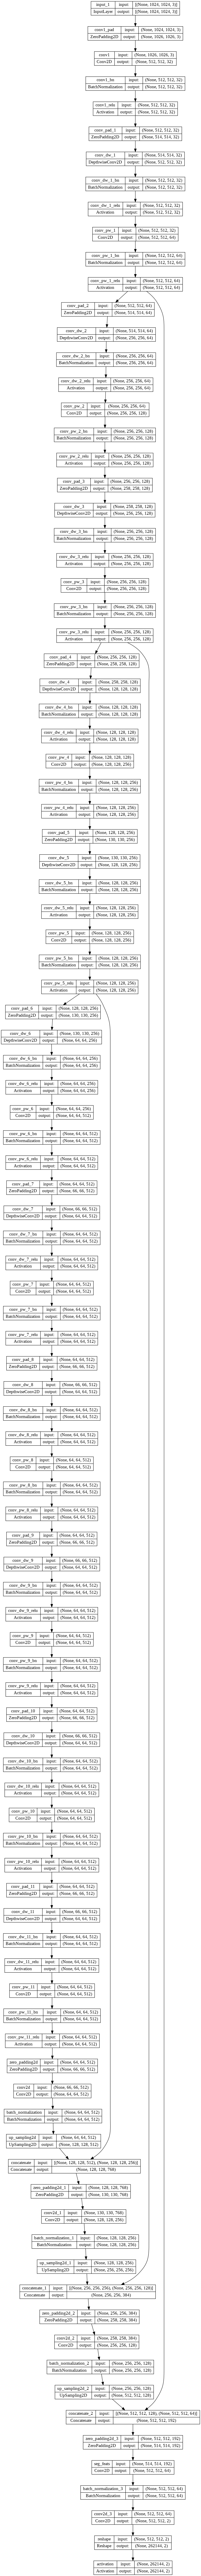

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [24]:

def masked_categorical_crossentropy(gt, pr):
    from keras.losses import categorical_crossentropy
    mask = 1 - gt[:, :, 0]
    return categorical_crossentropy(gt, pr) * mask

In [ ]:
check_dir='/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/simoid_weights/v1/'
model_checkpoint = ModelCheckpoint(check_dir+'/delineation.h5', save_weights_only=False,verbose=True)

In [25]:
def masked_categorical_crossentropy(gt, pr):
    from keras.losses import categorical_crossentropy
    mask = 1 - gt[:, :, 0]
    return categorical_crossentropy(gt, pr) * mask

In [26]:

def find_latest_checkpoint(checkpoints_path, fail_safe=True):

    # This is legacy code, there should always be a "checkpoint" file in your directory

    def get_epoch_number_from_path(path):
        return path.replace(checkpoints_path, "").strip(".")

    # Get all matching files
    all_checkpoint_files = glob.glob(checkpoints_path + ".*")
    if len(all_checkpoint_files) == 0:
        all_checkpoint_files = glob.glob(checkpoints_path + "*.*")
    all_checkpoint_files = [ff.replace(".index", "") for ff in
                            all_checkpoint_files]  # to make it work for newer versions of keras
    # Filter out entries where the epoc_number part is pure number
    all_checkpoint_files = list(filter(lambda f: get_epoch_number_from_path(f)
                                       .isdigit(), all_checkpoint_files))
    if not len(all_checkpoint_files):
        # The glob list is empty, don't have a checkpoints_path
        if not fail_safe:
            raise ValueError("Checkpoint path {0} invalid"
                             .format(checkpoints_path))
        else:
            return None

In [27]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [28]:
class CheckpointsCallback(Callback):
    def __init__(self, checkpoints_path):
        self.checkpoints_path = checkpoints_path

    def on_epoch_end(self, epoch, logs=None):
        if self.checkpoints_path is not None:
            self.model.save_weights(self.checkpoints_path + "." + str(epoch)+'.h5')
            print("saved ", self.checkpoints_path + "." + str(epoch)+'.h5')


def train(model,
          train_images,
          train_annotations,
          input_height=None,
          input_width=None,
          n_classes=None,
          verify_dataset=True,
          checkpoints_path=None,
          epochs=5,
          batch_size=2,
          validate=False,
          val_images=None,
          val_annotations=None,
          val_batch_size=2,
          auto_resume_checkpoint=False,
          load_weights=None,
          steps_per_epoch=512,
          val_steps_per_epoch=512,
          gen_use_multiprocessing=False,
          ignore_zero_class=False,
          optimizer_name='adam',
          do_augment=False,
          augmentation_name="aug_all",
          callbacks=None,
          custom_augmentation=None,
          other_inputs_paths=None,
          preprocessing=None,
          read_image_type=1  # cv2.IMREAD_COLOR = 1 (rgb),
                             # cv2.IMREAD_GRAYSCALE = 0,
                             # cv2.IMREAD_UNCHANGED = -1 (4 channels like RGBA)
         ):
    #from .models.all_models import model_from_name
    # check if user gives model name instead of the model object
     #if isinstance(model, six.string_types):
        # create the model from the name
        #assert (n_classes is not None), "Please provide the n_classes"
         #if (input_height is not None) and (input_width is not None):
            #model = model_from_name[model](
               # n_classes, input_height=input_height, input_width=input_width)
       # else:
          #  model = model_from_name[model](n_classes)

    n_classes = model.n_classes
    input_height = model.input_height
    input_width = model.input_width
    output_height = model.output_height
    output_width = model.output_width

    if validate:
        assert val_images is not None
        assert val_annotations is not None

    if optimizer_name is not None:

        if ignore_zero_class:
            loss_k = masked_categorical_crossentropy
        else:
            loss_k = 'binary_crossentropy'
            #loss_k = 'categorical_crossentropy'
        loss_k = 'binary_crossentropy'
        
        #model.compile(loss=loss_k,optimizer=optimizer_name,metrics=['accuracy'])
        model.compile(loss=loss_k,optimizer=optimizer_name, metrics = ['accuracy', Precision(), Recall(),dice_coef, jacard_coef])
    if checkpoints_path is not None:
        config_file = checkpoints_path + "_config.json"
        dir_name = os.path.dirname(config_file)
        if ( not os.path.exists(dir_name) )  and len( dir_name ) > 0 :
            os.makedirs(dir_name)

        with open(config_file, "w") as f:
            json.dump({
                "model_class": model.model_name,
                "n_classes": n_classes,
                "input_height": input_height,
                "input_width": input_width,
                "output_height": output_height,
                "output_width": output_width
            }, f)

    if load_weights is not None and len(load_weights) > 0:
        print("Loading weights from ", load_weights)
        model.load_weights(load_weights)

    initial_epoch = 0

    if auto_resume_checkpoint and (checkpoints_path is not None):
        latest_checkpoint = find_latest_checkpoint(checkpoints_path)
        if latest_checkpoint is not None:
            print("Loading the weights from latest checkpoint ",
                  latest_checkpoint)
            model.load_weights(latest_checkpoint)

            initial_epoch = int(latest_checkpoint.split('.')[-1])

    if verify_dataset:
        print("Verifying training dataset")
        verified = verify_segmentation_dataset(train_images,
                                               train_annotations,
                                               n_classes)
        assert verified
        if validate:
            print("Verifying validation dataset")
            verified = verify_segmentation_dataset(val_images,
                                                   val_annotations,
                                                   n_classes)
            assert verified

    train_gen = image_segmentation_generator(
        train_images, train_annotations,  batch_size,  n_classes,
        input_height, input_width, output_height, output_width,
        do_augment=do_augment, augmentation_name=augmentation_name,
        custom_augmentation=custom_augmentation, other_inputs_paths=other_inputs_paths,
        preprocessing=preprocessing, read_image_type=read_image_type)

    if validate:
        val_gen = image_segmentation_generator(
            val_images, val_annotations,  val_batch_size,
            n_classes, input_height, input_width, output_height, output_width,
            other_inputs_paths=other_inputs_paths,
            preprocessing=preprocessing, read_image_type=read_image_type)

    if callbacks is None and (not checkpoints_path is  None) :
        default_callback = ModelCheckpoint(
                filepath=checkpoints_path + ".{epoch:05d}.h5",
                save_weights_only=True,
                verbose=True
            )

        if sys.version_info[0] < 3: # for pyhton 2 
            default_callback = CheckpointsCallback(checkpoints_path)

        callbacks = [
            default_callback
        ]

    if callbacks is None:
        callbacks = []

    if not validate:
        k=model.fit(train_gen, steps_per_epoch=steps_per_epoch,
                  epochs=epochs, callbacks=callbacks, initial_epoch=initial_epoch)
    else:
        k=model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch)
    return k

# Training 

In [29]:
import keras
print(keras.__version__)

2.9.0


In [30]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [31]:
from tensorflow.keras.optimizers import *

In [43]:
history=train(model,
          train_images="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/image_data/",
          train_annotations= "/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/mask_data/",
          input_height=1024,
          input_width=1024,
          n_classes=2,
          verify_dataset=True,
          checkpoints_path="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/simoid_weights/v2/delineation_test_all",
          epochs=10,
          batch_size=3,
          validate=True,
          val_images="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/mobile_image/",
          val_annotations="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/mobile_mask_png/",
          val_batch_size=10,
          auto_resume_checkpoint=False,
          load_weights=None,
          steps_per_epoch=612,
          val_steps_per_epoch=612,
          gen_use_multiprocessing=False,
          ignore_zero_class=False,
          optimizer_name=Adam(learning_rate= 1e-2),#'adam',
          do_augment=False,
          augmentation_name="aug_all",
          callbacks=None,
          custom_augmentation=None,
          other_inputs_paths=None,
          preprocessing=None,
          read_image_type=1  
         )

Verifying training dataset


100%|██████████| 454/454 [00:11<00:00, 40.64it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 264/264 [00:05<00:00, 48.40it/s]


Dataset verified! 
Epoch 1/10
612/612 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.8984 - precision_8: 0.8983 - recall_8: 0.8984 - dice_coef: 0.8501 - jacard_coef: 0.7460
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/simoid_weights/v2/delineation_test_all.00001.h5
612/612 [==============================] - 938s 2s/step - loss: 0.2636 - accuracy: 0.8984 - precision_8: 0.8983 - recall_8: 0.8984 - dice_coef: 0.8501 - jacard_coef: 0.7460 - val_loss: 0.4298 - val_accuracy: 0.8482 - val_precision_8: 0.8480 - val_recall_8: 0.8486 - val_dice_coef: 0.8330 - val_jacard_coef: 0.7176
Epoch 2/10
612/612 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.9199 - precision_8: 0.9199 - recall_8: 0.9198 - dice_coef: 0.8821 - jacard_coef: 0.7941
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/simoid_weights/v2/delineation_test_all.00002.h5
612

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/new/delineation_softmax_last.h5")

In [33]:
model.save("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/simoid_weights/v3/delineation_softmax_last_sigmoid_today_v1_30.h5")

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/new/delineation_softmax_last")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/new/delineation_softmax_last/assets


In [ ]:
trained_modelf = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/delineation_softmax_last.h5",
                                            custom_objects={"acc":keras.metrics.Accuracy, "prec": keras.metrics.Precision,"recall": keras.metrics.Recall,"dice_coef":dice_coef, "jacard_coef":jacard_coef})

In [ ]:
from keras.metrics import Precision, Recall

In [ ]:
second_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/delineation_sigmoid_2.h5")

In [ ]:
#"/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/delineation_sigmoid.h5"  had 0.91 accuracy

In [ ]:
trained_modelf = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/delineation_sigmoid.h5",
                                            custom_objects={"acc":keras.metrics.Accuracy, "prec": keras.metrics.Precision,"recall": keras.metrics.Recall,"dice_coef":dice_coef, "jacard_coef":jacard_coef})

In [ ]:
trained_modelf = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/delineation_sigmoid_2",
                                            custom_objects={"acc":keras.metrics.Accuracy, "prec": keras.metrics.Precision,"recall": keras.metrics.Recall,"dice_coef":dice_coef, "jacard_coef":jacard_coef})

In [ ]:
#model.save("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/delineation_sigmoid.h5")

In [ ]:
model.load_weights("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/delineation_sigmoid.h5")

new_test

In [ ]:


import keras

trained_modelf = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/simoid_weights/v2/delineation_test_all.00020.h5",
                                            custom_objects={"acc":keras.metrics.Accuracy, "prec": keras.metrics.Precision,"recall": keras.metrics.Recall,"dice_coef":dice_coef, "jacard_coef":jacard_coef})

test

In [ ]:
from os import listdir
from os.path import join
from os.path import isfile
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
import tensorflow as tf
def testGenerator(test_path,num_image = 30,target_size = (1024,1024),flag_multi_class = False,as_gray = False):
  files= [f for f in listdir(test_path) if isfile(join(test_path, f))]
  for i in files:
        img = io.imread(os.path.join(test_path,"%s"%i))
        #img = img / img.max()
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img.astype(np.float16)
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
        
    img_out= img_out/img_out.max()
    return img_out.astype(np.float16)

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%s.tif"), img)

In [ ]:
testGene = testGenerator("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/result/image_jpg/9.jpg")

In [ ]:

#results = model.predict_generator(testGene, 5,verbose=1)

import cv2
path=""
#inp=cv2.imread(sys.path)

In [ ]:
image_input="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/result/image_jpg/9.jpg"
img = cv2.imread(image_input)

In [ ]:
pr = model.predict(np.array([img]))[0]


In [ ]:
pr

array([[0.71436054, 0.25040004],
       [0.8732782 , 0.2910352 ],
       [0.89049965, 0.19289178],
       ...,
       [0.85116947, 0.24014167],
       [0.7955637 , 0.28276086],
       [0.70436597, 0.33332497]], dtype=float32)

In [ ]:

def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
        
    img_out= img_out/img_out.max()
    return img_out.astype(np.float16)


In [ ]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])
def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    files= [os.path.splitext(os.path.basename(file))[0] for file in os.listdir(save_path)] 
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_/home/nteupe/data/sat_shp/shapesDICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"{}_predict.tif".format(files[i])), img)

In [ ]:
for i,item in enumerate(pr):
  img = labelVisualize(2,COLOR_DICT,item)  # if flag_multi_class else item[:,:,0]
  io.imsave("/content/drive/MyDrive/Colab Notebooks/plot_delineation/predict.tif", img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: /content/drive/MyDrive/Colab Notebooks/plot_delineation/predict.tif is a low contrast image
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
import numpy
with numpy.printoptions(threshold=numpy.inf):
    print(pr)

In [ ]:
pr.shape

(262144, 2)

# Visualisation of Metric plot

## Acuracy plot

dict_keys(['loss', 'accuracy', 'precision_7', 'recall_7', 'dice_coef', 'jacard_coef', 'val_loss', 'val_accuracy', 'val_precision_7', 'val_recall_7', 'val_dice_coef', 'val_jacard_coef'])


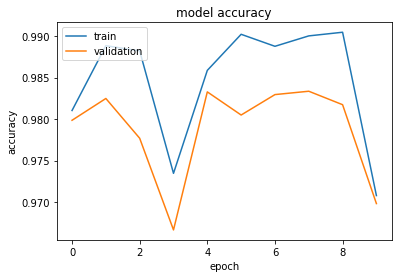

In [41]:
import matplotlib.pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


## loss plot

dict_keys(['loss', 'accuracy', 'precision_7', 'recall_7', 'dice_coef', 'jacard_coef', 'val_loss', 'val_accuracy', 'val_precision_7', 'val_recall_7', 'val_dice_coef', 'val_jacard_coef'])


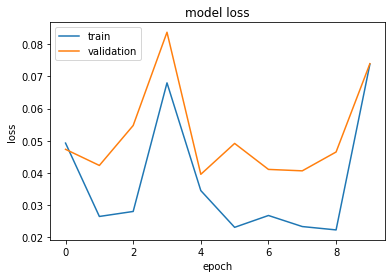

In [42]:
import matplotlib.pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Precision plot

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'dice_coef', 'jacard_coef', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_dice_coef', 'val_jacard_coef'])


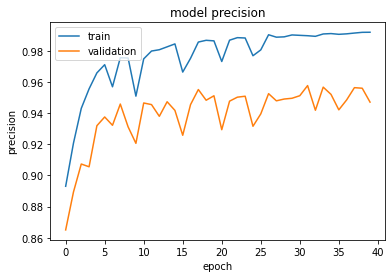

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Recall plot

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'dice_coef', 'jacard_coef', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_dice_coef', 'val_jacard_coef'])


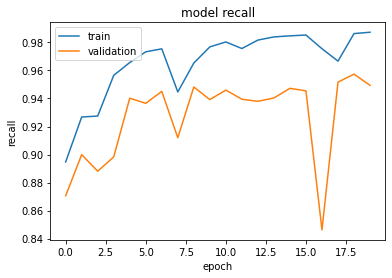

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##  Dice_coef plot

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'dice_coef', 'jacard_coef', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_dice_coef', 'val_jacard_coef'])


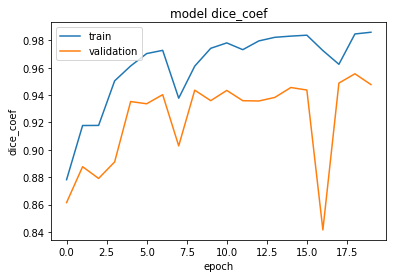

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##  Jacard_coef plot

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'dice_coef', 'jacard_coef', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_dice_coef', 'val_jacard_coef'])


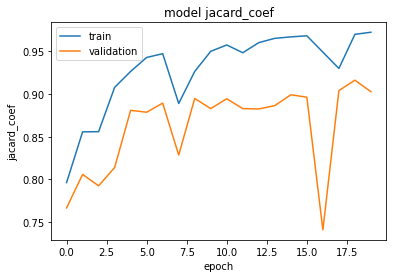

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['jacard_coef'])
plt.plot(history.history['val_jacard_coef'])
plt.title('model jacard_coef')
plt.ylabel('jacard_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

ing m

In [ ]:
import numpy as np

EPS = 1e-12


def get_iou(gt, pr, n_classes):
    class_wise = np.zeros(n_classes)
    for cl in range(n_classes):
        intersection = np.sum((gt == cl)*(pr == cl))
        union = np.sum(np.maximum((gt == cl), (pr == cl)))
        iou = float(intersection)/(union + EPS)
        class_wise[cl] = iou
    return class_wise

In [ ]:
import glob
import random
import json
import os
import six

import cv2
import numpy as np
from tqdm import tqdm
from time import time

In [ ]:
#DATA_LOADER_SEED=1254
#random.seed(DATA_LOADER_SEED)


def model_from_checkpoint_path(checkpoints_path):

    from .models.all_models import model_from_name
    assert (os.path.isfile(checkpoints_path+"_config.json")
            ), "Checkpoint not found."
    model_config = json.loads(
        open(checkpoints_path+"_config.json", "r").read())
    latest_weights = find_latest_checkpoint(checkpoints_path)
    assert (latest_weights is not None), "Checkpoint not found."
    model = model_from_name[model_config['model_class']](
        model_config['n_classes'], input_height=model_config['input_height'],
        input_width=model_config['input_width'])
    print("loaded weights ", latest_weights)
    status = model.load_weights(latest_weights)

    if status is not None:
        status.expect_partial()

    return model



def get_colored_segmentation_image(seg_arr, n_classes, colors=class_colors):
    output_height = seg_arr.shape[0]
    output_width = seg_arr.shape[1]

    seg_img = np.zeros((output_height, output_width, 3))

    for c in range(n_classes):
        seg_arr_c = seg_arr[:, :] == c
        seg_img[:, :, 0] += ((seg_arr_c)*(colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg_arr_c)*(colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg_arr_c)*(colors[c][2])).astype('uint8')

    return seg_img
def overlay_seg_image(inp_img, seg_img):
    orininal_h = inp_img.shape[0]
    orininal_w = inp_img.shape[1]
    seg_img = cv2.resize(seg_img, (orininal_w, orininal_h), interpolation=cv2.INTER_NEAREST)

    fused_img = (inp_img/2 + seg_img/2).astype('uint8')
    return fused_img


def concat_lenends(seg_img, legend_img):

    new_h = np.maximum(seg_img.shape[0], legend_img.shape[0])
    new_w = seg_img.shape[1] + legend_img.shape[1]

    out_img = np.zeros((new_h, new_w, 3)).astype('uint8') + legend_img[0, 0, 0]

    out_img[:legend_img.shape[0], :  legend_img.shape[1]] = np.copy(legend_img)
    out_img[:seg_img.shape[0], legend_img.shape[1]:] = np.copy(seg_img)

    return 
def visualize_segmentation(seg_arr, inp_img=None, n_classes=None,
                           colors=class_colors, class_names=None,
                           overlay_img=False, show_legends=False,
                           prediction_width=None, prediction_height=None):

    if n_classes is None:
        n_classes = np.max(seg_arr)

    seg_img = get_colored_segmentation_image(seg_arr, n_classes, colors=colors)

    if inp_img is not None:
        original_h = inp_img.shape[0]
        original_w = inp_img.shape[1]
        seg_img = cv2.resize(seg_img, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    if (prediction_height is not None) and (prediction_width is not None):
        seg_img = cv2.resize(seg_img, (prediction_width, prediction_height), interpolation=cv2.INTER_NEAREST)
        if inp_img is not None:
            inp_img = cv2.resize(inp_img,
                                 (prediction_width, prediction_height))

    if overlay_img:
        assert inp_img is not None
        seg_img = overlay_seg_image(inp_img, seg_img)

    if show_legends:
        assert class_names is not None
        legend_img = get_legends(class_names, colors=colors)

        seg_img = concat_lenends(seg_img, legend_img)

    return seg_img

## Prediction function 

In [ ]:
inp = cv2.imread("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/image_data/9.jpg",1)

In [ ]:
output_width = 1024
output_height = 1024
input_width = model.input_width
input_height = model.input_height
n_classes = 2

x = get_image_array(inp, input_width, input_height,
                        ordering=IMAGE_ORDERING)


In [ ]:
pr = model.predict(np.array([x]))[0]
    

1/1 [==============================] - 0s 24ms/step


In [ ]:
pr

array([[6.0483273e-03, 9.9395162e-01],
       [3.0397912e-04, 9.9969602e-01],
       [1.1359938e-04, 9.9988639e-01],
       ...,
       [8.3081366e-05, 9.9991691e-01],
       [3.3793977e-04, 9.9966204e-01],
       [1.1467895e-02, 9.8853207e-01]], dtype=float32)

In [ ]:
pr = pr.reshape((512,  512, 2)).argmax(axis=2)

In [ ]:
j=(pr * 255)

In [ ]:
cv2.imwrite("/content/drive/MyDrive/Colab Notebooks/test_results.jpg", j)

True

In [ ]:


def predict(model=None, inp=None, out_fname=None,
            checkpoints_path=None, overlay_img=False,
            class_names=None, show_legends=False, colors=class_colors,
            prediction_width=None, prediction_height=None,
            read_image_type=1):

    if model is None and (checkpoints_path is not None):
        model = model_from_checkpoint_path(checkpoints_path)

    assert (inp is not None)
    assert ((type(inp) is np.ndarray) or isinstance(inp, six.string_types)),\
        "Input should be the CV image or the input file name"

    if isinstance(inp, six.string_types):
        inp = cv2.imread(inp, read_image_type)

    assert (len(inp.shape) == 3 or len(inp.shape) == 1 or len(inp.shape) == 4), "Image should be h,w,3 "


    #model.n_classes=2
    ##model.output_width=512
    #model.output_height=512
    #model.input_width=1024
    #model.input_height=1024
    output_width = model.output_width
    output_height = model.output_height
    input_width = model.input_width
    input_height = model.input_height
    n_classes = model.n_classes

    x = get_image_array(inp, input_width, input_height,
                        ordering=IMAGE_ORDERING)
    pr = model.predict(np.array([x]))[0]
    pr = pr.reshape((output_height,  output_width, n_classes)).argmax(axis=2)

    seg_img = visualize_segmentation(pr, inp, n_classes=n_classes,
                                     colors=colors, overlay_img=overlay_img,
                                     show_legends=show_legends,
                                     class_names=class_names,
                                     prediction_width=prediction_width,
                                     prediction_height=prediction_height)

    if out_fname is not None:
        cv2.imwrite(out_fname, seg_img)

    return pr


In [ ]:
model.n_classes


## Evaluation function

In [ ]:
def evaluate(model=None, inp_images=None, annotations=None,
             inp_images_dir=None, annotations_dir=None, checkpoints_path=None, read_image_type=1):

    if model is None:
        assert (checkpoints_path is not None),\
                "Please provide the model or the checkpoints_path"
        model = model_from_checkpoint_path(checkpoints_path)

    if inp_images is None:
        assert (inp_images_dir is not None),\
                "Please provide inp_images or inp_images_dir"
        assert (annotations_dir is not None),\
            "Please provide inp_images or inp_images_dir"

        paths = get_pairs_from_paths(inp_images_dir, annotations_dir)
        paths = list(zip(*paths))
        inp_images = list(paths[0])
        annotations = list(paths[1])

    assert type(inp_images) is list
    assert type(annotations) is list
    model.n_classes=2
    model.output_width=512
    model.output_height=512
    model.input_width=1024
    model.input_height=1024
    tp = np.zeros(model.n_classes)
    fp = np.zeros(model.n_classes)
    fn = np.zeros(model.n_classes)
    n_pixels = np.zeros(model.n_classes)

    for inp, ann in tqdm(zip(inp_images, annotations)):
        pr = predict(model, inp, read_image_type=read_image_type)
        gt = get_segmentation_array(ann, model.n_classes,
                                    model.output_width, model.output_height,
                                    no_reshape=True, read_image_type=read_image_type)
        gt = gt.argmax(-1)
        pr = pr.flatten()
        gt = gt.flatten()

        for cl_i in range(model.n_classes):

            tp[cl_i] += np.sum((pr == cl_i) * (gt == cl_i))
            fp[cl_i] += np.sum((pr == cl_i) * ((gt != cl_i)))
            fn[cl_i] += np.sum((pr != cl_i) * ((gt == cl_i)))
            n_pixels[cl_i] += np.sum(gt == cl_i)

    cl_wise_score = tp / (tp + fp + fn + 0.000000000001)
    n_pixels_norm = n_pixels / np.sum(n_pixels)
    frequency_weighted_IU = np.sum(cl_wise_score*n_pixels_norm)
    mean_IU = np.mean(cl_wise_score)

    return {
        "frequency_weighted_IU": frequency_weighted_IU,
        "mean_IU": mean_IU,
        "class_wise_IU": cl_wise_score
    }

In [ ]:
evaluate(trained_modelf, inp_images_dir="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/mobile_image/", annotations_dir="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/mobile_mask_png/",
          checkpoints_path="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/simoid_weight/delineation")


In [ ]:
evaluate(trained_modelf, inp_images_dir="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/mobile_image/", annotations_dir="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/mobile_mask_png/",
          checkpoints_path="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/simoid_weight/delineation")


In [ ]:
evaluate(model, inp_images_dir="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/mobile_image/", annotations_dir="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/mobile_mask_png/",
 checkpoints_path="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/simoid_weight/delineation")

0it [00:00, ?it/s]

1/1 [==============================] - 3s 3s/step


1it [00:03,  3.97s/it]

1/1 [==============================] - 0s 25ms/step


2it [00:05,  2.62s/it]

1/1 [==============================] - 0s 25ms/step


3it [00:08,  2.92s/it]

1/1 [==============================] - 0s 23ms/step


4it [00:09,  2.15s/it]

1/1 [==============================] - 0s 25ms/step


5it [00:11,  2.07s/it]

1/1 [==============================] - 0s 26ms/step


6it [00:12,  1.68s/it]

1/1 [==============================] - 0s 24ms/step


7it [00:16,  2.38s/it]

1/1 [==============================] - 0s 24ms/step


8it [00:18,  2.35s/it]

1/1 [==============================] - 0s 24ms/step


9it [00:19,  1.96s/it]

1/1 [==============================] - 0s 23ms/step


10it [00:22,  2.17s/it]

1/1 [==============================] - 0s 24ms/step


11it [00:24,  2.18s/it]

1/1 [==============================] - 0s 23ms/step


12it [00:27,  2.37s/it]

1/1 [==============================] - 0s 24ms/step


13it [00:30,  2.56s/it]

1/1 [==============================] - 0s 23ms/step


14it [00:32,  2.32s/it]

1/1 [==============================] - 0s 24ms/step


15it [00:34,  2.26s/it]

1/1 [==============================] - 0s 24ms/step


16it [00:35,  1.87s/it]

1/1 [==============================] - 0s 23ms/step


17it [00:37,  1.81s/it]

1/1 [==============================] - 0s 24ms/step


18it [00:39,  1.93s/it]

1/1 [==============================] - 0s 23ms/step


19it [00:42,  2.24s/it]

1/1 [==============================] - 0s 24ms/step


20it [00:44,  2.15s/it]

1/1 [==============================] - 0s 24ms/step


21it [00:47,  2.35s/it]

1/1 [==============================] - 0s 24ms/step


22it [00:47,  1.93s/it]

1/1 [==============================] - 0s 25ms/step


23it [00:49,  1.94s/it]

1/1 [==============================] - 0s 24ms/step


24it [00:50,  1.64s/it]

1/1 [==============================] - 0s 25ms/step


25it [00:52,  1.71s/it]

1/1 [==============================] - 0s 24ms/step


26it [00:56,  2.31s/it]

1/1 [==============================] - 0s 24ms/step


27it [00:58,  2.14s/it]

1/1 [==============================] - 0s 24ms/step


28it [01:00,  2.23s/it]

1/1 [==============================] - 0s 24ms/step


29it [01:02,  2.21s/it]

1/1 [==============================] - 0s 24ms/step


30it [01:04,  2.09s/it]

1/1 [==============================] - 0s 26ms/step


31it [01:05,  1.84s/it]

1/1 [==============================] - 0s 23ms/step


32it [01:07,  1.87s/it]

1/1 [==============================] - 0s 24ms/step


33it [01:08,  1.60s/it]

1/1 [==============================] - 0s 25ms/step


34it [01:10,  1.63s/it]

1/1 [==============================] - 0s 23ms/step


35it [01:12,  1.75s/it]

1/1 [==============================] - 0s 24ms/step


36it [01:13,  1.50s/it]

1/1 [==============================] - 0s 25ms/step


37it [01:16,  1.88s/it]

1/1 [==============================] - 0s 25ms/step


38it [01:19,  2.43s/it]

1/1 [==============================] - 0s 25ms/step


39it [01:20,  1.98s/it]

1/1 [==============================] - 0s 26ms/step


40it [01:23,  2.21s/it]

1/1 [==============================] - 0s 24ms/step


41it [01:24,  1.86s/it]

1/1 [==============================] - 0s 24ms/step


42it [01:25,  1.62s/it]

1/1 [==============================] - 0s 23ms/step


43it [01:27,  1.75s/it]

1/1 [==============================] - 0s 24ms/step


44it [01:29,  1.82s/it]

1/1 [==============================] - 0s 24ms/step


45it [01:30,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


46it [01:32,  1.70s/it]

1/1 [==============================] - 0s 24ms/step


47it [01:35,  2.03s/it]

1/1 [==============================] - 0s 26ms/step


48it [01:36,  1.72s/it]

1/1 [==============================] - 0s 24ms/step


49it [01:39,  2.03s/it]

1/1 [==============================] - 0s 24ms/step


50it [01:40,  1.72s/it]

1/1 [==============================] - 0s 24ms/step


51it [01:42,  1.76s/it]

1/1 [==============================] - 0s 25ms/step


52it [01:43,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


53it [01:44,  1.57s/it]

1/1 [==============================] - 0s 25ms/step


54it [01:47,  1.95s/it]

1/1 [==============================] - 0s 24ms/step


55it [01:50,  2.22s/it]

1/1 [==============================] - 0s 24ms/step


56it [01:52,  2.08s/it]

1/1 [==============================] - 0s 23ms/step


57it [01:53,  2.00s/it]

1/1 [==============================] - 0s 28ms/step


58it [01:57,  2.53s/it]

1/1 [==============================] - 0s 25ms/step


59it [01:58,  2.07s/it]

1/1 [==============================] - 0s 24ms/step


60it [02:04,  3.09s/it]

1/1 [==============================] - 0s 24ms/step


61it [02:06,  2.99s/it]

1/1 [==============================] - 0s 24ms/step


62it [02:08,  2.62s/it]

1/1 [==============================] - 0s 25ms/step


63it [02:12,  2.96s/it]

1/1 [==============================] - 0s 24ms/step


64it [02:14,  2.68s/it]

1/1 [==============================] - 0s 24ms/step


65it [02:15,  2.15s/it]

1/1 [==============================] - 0s 23ms/step


66it [02:19,  2.67s/it]

1/1 [==============================] - 0s 23ms/step


67it [02:21,  2.47s/it]

1/1 [==============================] - 0s 24ms/step


68it [02:22,  2.01s/it]

1/1 [==============================] - 0s 24ms/step


69it [02:23,  1.77s/it]

1/1 [==============================] - 0s 23ms/step


70it [02:24,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


71it [02:25,  1.34s/it]

1/1 [==============================] - 0s 24ms/step


72it [02:26,  1.31s/it]

1/1 [==============================] - 0s 24ms/step


73it [02:28,  1.61s/it]

1/1 [==============================] - 0s 24ms/step


74it [02:31,  1.77s/it]

1/1 [==============================] - 0s 24ms/step


75it [02:31,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


76it [02:33,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


77it [02:34,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


78it [02:38,  2.27s/it]

1/1 [==============================] - 0s 24ms/step


79it [02:40,  2.18s/it]

1/1 [==============================] - 0s 24ms/step


80it [02:42,  1.93s/it]

1/1 [==============================] - 0s 25ms/step


81it [02:44,  1.92s/it]

1/1 [==============================] - 0s 23ms/step


82it [02:47,  2.40s/it]

1/1 [==============================] - 0s 26ms/step


83it [02:49,  2.30s/it]

1/1 [==============================] - 0s 24ms/step


84it [02:50,  1.90s/it]

1/1 [==============================] - 0s 23ms/step


85it [02:51,  1.61s/it]

1/1 [==============================] - 0s 23ms/step


86it [02:52,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


87it [02:54,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


88it [02:57,  1.86s/it]

1/1 [==============================] - 0s 24ms/step


89it [02:58,  1.82s/it]

1/1 [==============================] - 0s 26ms/step


90it [03:00,  1.81s/it]

1/1 [==============================] - 0s 24ms/step


91it [03:05,  2.69s/it]

1/1 [==============================] - 0s 24ms/step


92it [03:07,  2.53s/it]

1/1 [==============================] - 0s 24ms/step


93it [03:09,  2.41s/it]

1/1 [==============================] - 0s 23ms/step


94it [03:13,  2.82s/it]

1/1 [==============================] - 0s 25ms/step


95it [03:14,  2.32s/it]

1/1 [==============================] - 0s 23ms/step


96it [03:16,  2.25s/it]

1/1 [==============================] - 0s 24ms/step


97it [03:19,  2.42s/it]

1/1 [==============================] - 0s 23ms/step


98it [03:20,  2.02s/it]

1/1 [==============================] - 0s 26ms/step


99it [03:22,  2.10s/it]

1/1 [==============================] - 0s 23ms/step


100it [03:40,  6.79s/it]

1/1 [==============================] - 0s 23ms/step


101it [03:41,  5.07s/it]

1/1 [==============================] - 0s 24ms/step


102it [03:43,  4.23s/it]

1/1 [==============================] - 0s 25ms/step


103it [03:47,  4.19s/it]

1/1 [==============================] - 0s 24ms/step


104it [03:51,  3.98s/it]

1/1 [==============================] - 0s 23ms/step


105it [03:52,  3.09s/it]

1/1 [==============================] - 0s 24ms/step


106it [03:53,  2.61s/it]

1/1 [==============================] - 0s 24ms/step


107it [03:55,  2.37s/it]

1/1 [==============================] - 0s 23ms/step


108it [03:58,  2.37s/it]

1/1 [==============================] - 0s 23ms/step


109it [04:00,  2.35s/it]

1/1 [==============================] - 0s 24ms/step


110it [04:01,  2.03s/it]

1/1 [==============================] - 0s 23ms/step


111it [04:03,  1.95s/it]

1/1 [==============================] - 0s 25ms/step


112it [04:06,  2.36s/it]

1/1 [==============================] - 0s 23ms/step


113it [04:09,  2.36s/it]

1/1 [==============================] - 0s 24ms/step


114it [04:11,  2.29s/it]

1/1 [==============================] - 0s 23ms/step


115it [04:12,  2.01s/it]

1/1 [==============================] - 0s 23ms/step


116it [04:14,  1.84s/it]

1/1 [==============================] - 0s 23ms/step


117it [04:17,  2.32s/it]

1/1 [==============================] - 0s 23ms/step


118it [04:21,  2.91s/it]

1/1 [==============================] - 0s 23ms/step


119it [04:23,  2.44s/it]

1/1 [==============================] - 0s 23ms/step


120it [04:25,  2.45s/it]

1/1 [==============================] - 0s 25ms/step


121it [04:26,  2.02s/it]

1/1 [==============================] - 0s 23ms/step


122it [04:26,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


123it [04:26,  1.09s/it]

1/1 [==============================] - 0s 23ms/step


124it [04:28,  1.07s/it]

1/1 [==============================] - 0s 25ms/step


125it [04:28,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


126it [04:28,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


127it [04:30,  1.00s/it]

1/1 [==============================] - 0s 23ms/step


128it [04:30,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


129it [04:30,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


130it [04:31,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


131it [04:33,  1.14s/it]

1/1 [==============================] - 0s 28ms/step


132it [04:35,  1.15s/it]

1/1 [==============================] - 0s 23ms/step


133it [04:35,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


134it [04:35,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


135it [04:35,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


136it [04:35,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


137it [04:35,  2.93it/s]

1/1 [==============================] - 0s 24ms/step


138it [04:38,  1.11it/s]

1/1 [==============================] - 0s 23ms/step


139it [04:38,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


140it [04:38,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


141it [04:39,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


142it [04:40,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


143it [04:40,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


144it [04:42,  1.03it/s]

1/1 [==============================] - 0s 23ms/step


145it [04:42,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


146it [04:42,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


147it [04:43,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


148it [04:46,  1.20s/it]

1/1 [==============================] - 0s 24ms/step


149it [04:46,  1.11it/s]

1/1 [==============================] - 0s 24ms/step


150it [04:46,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


151it [04:47,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


152it [04:47,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


153it [04:47,  2.16it/s]

1/1 [==============================] - 0s 24ms/step


154it [04:49,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


155it [04:49,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


156it [04:50,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


157it [04:50,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


158it [04:51,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


159it [04:51,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


160it [04:51,  2.45it/s]

1/1 [==============================] - 0s 24ms/step


161it [04:52,  2.96it/s]

1/1 [==============================] - 0s 24ms/step


162it [04:52,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


163it [04:52,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


164it [04:53,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


165it [04:56,  1.15s/it]

1/1 [==============================] - 0s 23ms/step


166it [04:56,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


167it [04:57,  1.13it/s]

1/1 [==============================] - 0s 23ms/step


168it [04:57,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


169it [04:57,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


170it [04:57,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


171it [04:58,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


172it [05:00,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


173it [05:00,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


174it [05:01,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


175it [05:02,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


176it [05:04,  1.18s/it]

1/1 [==============================] - 0s 23ms/step


177it [05:05,  1.15s/it]

1/1 [==============================] - 0s 23ms/step


178it [05:06,  1.26s/it]

1/1 [==============================] - 0s 23ms/step


179it [05:07,  1.06it/s]

1/1 [==============================] - 0s 26ms/step


180it [05:07,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


181it [05:09,  1.09s/it]

1/1 [==============================] - 0s 24ms/step


182it [05:10,  1.07s/it]

1/1 [==============================] - 0s 23ms/step


183it [05:11,  1.02s/it]

1/1 [==============================] - 0s 24ms/step


184it [05:12,  1.08s/it]

1/1 [==============================] - 0s 23ms/step


185it [05:12,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


186it [05:12,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


187it [05:13,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


188it [05:13,  2.53it/s]

1/1 [==============================] - 0s 24ms/step


189it [05:13,  3.05it/s]

1/1 [==============================] - 0s 24ms/step


190it [05:13,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


191it [05:13,  4.05it/s]

1/1 [==============================] - 0s 24ms/step


192it [05:14,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


193it [05:15,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


194it [05:15,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


195it [05:16,  2.49it/s]

1/1 [==============================] - 0s 23ms/step


196it [05:17,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


197it [05:19,  1.01s/it]

1/1 [==============================] - 0s 23ms/step


198it [05:19,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


199it [05:21,  1.19s/it]

1/1 [==============================] - 0s 23ms/step


200it [05:21,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


201it [05:22,  1.10it/s]

1/1 [==============================] - 0s 24ms/step


202it [05:23,  1.05s/it]

1/1 [==============================] - 0s 23ms/step


203it [05:24,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


204it [05:24,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


205it [05:25,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


206it [05:26,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


207it [05:26,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


208it [05:27,  1.14it/s]

1/1 [==============================] - 0s 23ms/step


209it [05:28,  1.11it/s]

1/1 [==============================] - 0s 23ms/step


210it [05:29,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


211it [05:29,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


212it [05:29,  2.32it/s]

1/1 [==============================] - 0s 24ms/step


213it [05:30,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


214it [05:30,  2.17it/s]

1/1 [==============================] - 0s 23ms/step


215it [05:31,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


216it [05:32,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


217it [05:34,  1.01it/s]

1/1 [==============================] - 0s 23ms/step


218it [05:34,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


219it [05:34,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


220it [05:34,  2.17it/s]

1/1 [==============================] - 0s 24ms/step


221it [05:34,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


222it [05:35,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


223it [05:37,  1.01it/s]

1/1 [==============================] - 0s 25ms/step


224it [05:38,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


225it [05:38,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


226it [05:40,  1.01s/it]

1/1 [==============================] - 0s 24ms/step


227it [05:40,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


228it [05:40,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


229it [05:40,  2.16it/s]

1/1 [==============================] - 0s 24ms/step


230it [05:40,  2.67it/s]

1/1 [==============================] - 0s 24ms/step


231it [05:41,  3.20it/s]

1/1 [==============================] - 0s 24ms/step


232it [05:41,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


233it [05:43,  1.12it/s]

1/1 [==============================] - 0s 24ms/step


234it [05:43,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


235it [05:43,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


236it [05:44,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


237it [05:46,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


238it [05:47,  1.03it/s]

1/1 [==============================] - 0s 23ms/step


239it [05:48,  1.04it/s]

1/1 [==============================] - 0s 23ms/step


240it [05:48,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


241it [05:49,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


242it [05:51,  1.17s/it]

1/1 [==============================] - 0s 24ms/step


243it [05:52,  1.10s/it]

1/1 [==============================] - 0s 23ms/step


244it [05:52,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


245it [05:52,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


246it [05:53,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


247it [05:53,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


248it [05:54,  2.26it/s]

1/1 [==============================] - 0s 23ms/step


249it [05:54,  2.74it/s]

1/1 [==============================] - 0s 24ms/step


250it [05:54,  3.22it/s]

1/1 [==============================] - 0s 24ms/step


251it [05:54,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


252it [05:54,  4.04it/s]

1/1 [==============================] - 0s 24ms/step


253it [05:56,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


254it [05:57,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


255it [05:59,  1.12s/it]

1/1 [==============================] - 0s 23ms/step


256it [05:59,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


257it [06:00,  1.02it/s]

1/1 [==============================] - 0s 23ms/step


258it [06:01,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


259it [06:01,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


260it [06:01,  2.21it/s]

1/1 [==============================] - 0s 24ms/step


261it [06:01,  2.73it/s]

1/1 [==============================] - 0s 23ms/step


262it [06:01,  3.28it/s]

1/1 [==============================] - 0s 24ms/step


263it [06:01,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


264it [06:03,  1.38s/it]


{'frequency_weighted_IU': 0.8990347020421362,
 'mean_IU': 0.8749600734534626,
 'class_wise_IU': array([0.82080476, 0.92911538])}

In [ ]:
evaluate(model, inp_images_dir="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/mobile_image/", annotations_dir="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/mobile_mask_png/",
 checkpoints_path="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/simoid_weights/v2/delineation_test_all")

# Evaluating saved weights

Nouvelle section

In [ ]:
from  datetime import datetime

In [ ]:
current_datetime= datetime.now()

In [ ]:

print( datetime.now())

2022-07-15 17:45:30.917076


In [ ]:
trained_modelf.output_shape

(None, 262144, 2)

In [ ]:

from  datetime import datetime
print(datetime.now())
predict_path="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/dagana/output/output/"
import os
file_names=os.listdir(predict_path)
predict_out="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/dagana/output/test/"
for i in range(len(file_names)):
  out =predict( model,
    inp=predict_path+file_names[i],
    out_fname=predict_out+file_names[i][:-4]+'.jpg'
    )

print( datetime.now())

In [ ]:

from  datetime import datetime
print(datetime.now())
predict_path="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/dagana/output1/output/"
import os
file_names=os.listdir(predict_path)
predict_out="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/dagana/output1/masks/"
for i in range(len(file_names)):
  out =predict( model,
    inp=predict_path+file_names[i],
    out_fname=predict_out+file_names[i][:-4]+'.jpg'
    )

print( datetime.now())

2022-10-23 16:08:15.967921
1/1 [==============================] - 0s 24ms/step


KeyboardInterrupt: ignored

In [ ]:
model.save("delineation_softmax_last_05_11.h5")

In [ ]:
from google.colab import files
files.download("delineation_softmax_last_05_11.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('delineation_softmax_last_05_11.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/new/delineation_softmax_last_03_08_202")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/new/delineation_softmax_last_03_08_202/assets


In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/delineation_20_07_2022.h5")

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/24-06/mix/weights/delineation_softmax_last_last")

In [ ]:
evaluate(model, inp_images_dir="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/mobile_image/", annotations_dir="/content/drive/MyDrive/Colab Notebooks/sentinel/Training/data/mobile_mask_png/")